In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import os
from os import environ
from pathlib import Path
from typing import List

import torch
import pandas as pd
import numpy as np

from hydra import initialize, compose
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf

from einops import rearrange

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from bliss.surveys.des import DarkEnergySurvey, DESDownloader

from pathlib import Path
from hydra import initialize, compose
from bliss.main import predict
import case_studies.galaxy_clustering.utils.diagnostics as diagnostics
from astropy.io import fits
from astropy.visualization import make_lupton_rgb

In [3]:
environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
with initialize(config_path="../conf/", version_base=None):
    cfg = compose("config")

In [5]:
cfg.predict

{'dataset': '${surveys.sdss}', 'trainer': {'_target_': 'pytorch_lightning.Trainer', 'accelerator': 'gpu', 'precision': '${train.trainer.precision}', 'logger': None, 'devices': [6, 5], 'strategy': 'ddp', 'callbacks': ['${predict.callbacks.writer}']}, 'encoder': '${encoder}', 'weight_save_path': '/home/kapnadak/bliss_output/version_92/checkpoints/best_encoder.ckpt', 'device': 'cuda:0', 'cached_dataset': {'_target_': 'case_studies.galaxy_clustering.inference.cached_dataset.CachedDESModule', 'cached_data_path': '/nfs/turbo/lsa-regier/scratch/gapatron/desdr-server.ncsa.illinois.edu/despublic/dr2_tiles', 'tiles_per_img': 64, 'batch_size': 2, 'num_workers': 4}, 'callbacks': {'writer': {'_target_': 'case_studies.galaxy_clustering.inference.inference_callbacks.DESPredictionsWriter', 'output_dir': '/data/scratch/des/dr2_detection_output/run_1', 'write_interval': 'batch'}}, 'output_save_path': '/data/scratch/des/dr2_detection_output/run_0'}

In [6]:
encoder = instantiate(cfg.predict.encoder)
enc_state_dict = torch.load(cfg.predict.weight_save_path)
enc_state_dict = enc_state_dict["state_dict"]
encoder.load_state_dict(enc_state_dict)
#dataset = instantiate(cfg.cached_simulator)
#trainer = instantiate(cfg.predict.trainer)

<All keys matched successfully>

In [7]:
cfg.predict.encoder

{'_target_': 'case_studies.galaxy_clustering.encoder.encoder.GalaxyClusterEncoder', 'survey_bands': ['g', 'r', 'i', 'z'], 'reference_band': 2, 'tile_slen': '${prior.tile_slen}', 'optimizer_params': {'lr': 0.001}, 'scheduler_params': {'milestones': [32], 'gamma': 0.1}, 'image_normalizers': '${my_image_normalizers}', 'var_dist': {'_target_': 'case_studies.galaxy_clustering.encoder.variational_dist.GalaxyClusterVariationalDist', 'tile_slen': '${encoder.tile_slen}', 'factors': '${variational_factors}'}, 'matcher': {'_target_': 'bliss.encoder.metrics.CatalogMatcher', 'dist_slack': 1.0, 'mag_slack': None, 'mag_band': 2}, 'mode_metrics': {'_target_': 'torchmetrics.MetricCollection', '_convert_': 'partial', 'metrics': '${my_metrics}'}, 'sample_metrics': {'_target_': 'torchmetrics.MetricCollection', '_convert_': 'partial', 'metrics': '${my_metrics}'}, 'sample_image_renders': {'_target_': 'torchmetrics.MetricCollection', 'metrics': [{'_target_': 'bliss.encoder.sample_image_renders.PlotSampleImag

In [8]:
DES_SVA_TILES = pd.read_pickle("/data/scratch/des/sva_map.pickle")
CACHED_DATA_PATH = (
    "/nfs/turbo/lsa-regier/scratch/gapatron/desdr-server.ncsa.illinois.edu/despublic/dr2_tiles"
)
DES_BANDS = ("g", "r", "i", "z")
GROUNDTRUTH_PATH = "/data/scratch/des/redmapper_groundtruth"

In [9]:
DES_TILE = np.random.choice(DES_SVA_TILES)
DES_TILE

'DES0457-5748'

In [10]:
directory_path = f"{CACHED_DATA_PATH}/{DES_TILE}"
dir_files = {
            band: [
                f for f in os.listdir(f"{directory_path}") if f.endswith(f"{band}_nobkg.fits.fz")
            ][0]
            for band in DES_BANDS
        }
image_bands = []
for band in DES_BANDS:
    band_filepath = f"{directory_path}/{dir_files[band]}"
    with fits.open(band_filepath) as f:
        # Data seems to be on HDU 1, not 0.
        hud = torch.from_numpy(f[1].data)
    image_bands.append(hud.data.unsqueeze(0))

full_image = torch.cat(image_bands, axis=0)
full_image.shape

torch.Size([4, 10000, 10000])

In [11]:
item = full_image.unfold(dimension=1, size=2560, step=2480).unfold(dimension=2, size=2560, step=2480)
item.shape

torch.Size([4, 4, 4, 2560, 2560])

In [12]:
outputs = torch.zeros((4,4,10,10))

for i in range(4):
    for j in range(4):
        image = item[:,i,j,:,:].unsqueeze(0)
        batch = {"images": image, "background": torch.zeros_like(image)}
        batch_size, _n_bands, h, w = batch["images"].shape[0:4]
        ht, wt = h // encoder.tile_slen, w // encoder.tile_slen

        input_lst = [inorm.get_input_tensor(batch) for inorm in encoder.image_normalizers]
        x = torch.cat(input_lst, dim=2)
        x_features = encoder.features_net(x)
        mask = torch.zeros([batch_size, ht, wt])
        context = encoder.make_context(None, mask)
        x_cat_marginal = encoder.catalog_net(x_features, context)
        outputs[i,j,:,:] = encoder.var_dist.sample(x_cat_marginal, use_mode=True)["membership"].squeeze()
outputs = outputs.bool()


In [13]:
gt_filename = f"/{GROUNDTRUTH_PATH}/{DES_TILE}_redmapper_groundtruth.npy"
gt_memberships = torch.from_numpy(np.load(gt_filename))
unfolded_gt = gt_memberships.unfold(dimension=0, size=2560, step=2480).unfold(
    dimension=1, size=2560, step=2480
)
pred_memberships = torch.repeat_interleave(outputs, repeats=encoder.tile_slen, dim=2)
pred_memberships = torch.repeat_interleave(pred_memberships, repeats=encoder.tile_slen, dim=3)
tp = (pred_memberships * unfolded_gt).sum()
tn = (~pred_memberships * ~unfolded_gt).sum()
fp = (pred_memberships * ~unfolded_gt).sum()
fn = (~pred_memberships * unfolded_gt).sum()
acc = (tp + tn) / (tp + tn + fp + fn)
prec = tp / (tp + fp + 1e-6)
rec = tp / (tp + fn + 1e-6)
f1 = 2 * prec * rec / (prec + rec + 1e-6)
print(f"Accuracy: {acc}")
print(f"Precision: {prec}")
print(f"Recall: {rec}")
print(f"F1: {f1}")

Accuracy: 0.9720273613929749
Precision: 0.0
Recall: 0.0
F1: 0.0


In [14]:
def blend_images(original, overlay, alpha=0.5, img_crop=0):
    # Ensure the original image is in float
    if original.max() > 1.0:
        original = original / 255.0
    # Blend the images
    blended = original * (1 - alpha) + overlay * alpha
    blended = blended[img_crop: blended.shape[0] - img_crop, img_crop: blended.shape[1] - img_crop]
    print(blended.shape)
    return blended

(10000, 10000, 3)


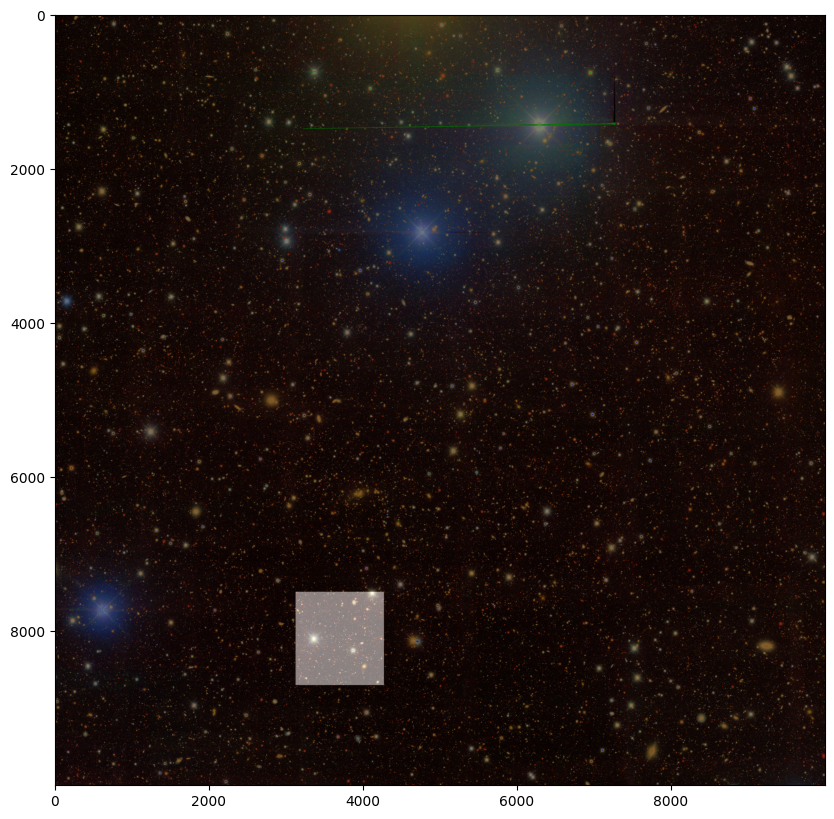

In [15]:
rgb_default = make_lupton_rgb(full_image[2,:,:], full_image[1,:,:], full_image[0,:,:])
overlay = gt_memberships.unsqueeze(2).repeat(1,1,3).numpy()
blended = blend_images(rgb_default, overlay)
plt.figure(figsize=(10,10))
plt.imshow(blended)

In [19]:
rearranged_memberships = rearrange(pred_memberships, 'd0 d1 d2 d3 -> (d0 d2) (d1 d3)')
row_include = torch.from_numpy(np.concatenate([np.arange(0,2560), np.arange(2640,5120), np.arange(5200,7680), np.arange(7760,10240)]))
folded_outputs = torch.index_select(rearranged_memberships, 0, row_include)
folded_outputs = torch.index_select(folded_outputs, 1, row_include)

(10000, 10000, 3)


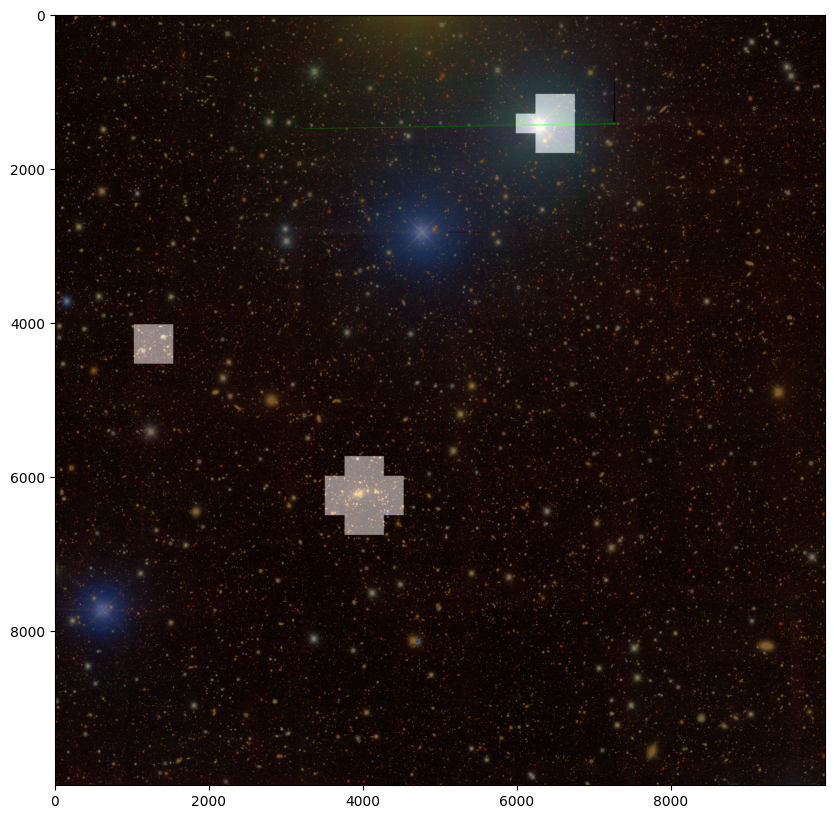

In [20]:
rgb_default = make_lupton_rgb(full_image[2,:,:], full_image[1,:,:], full_image[0,:,:])
overlay = folded_outputs.unsqueeze(2).repeat(1,1,3).numpy()
blended = blend_images(rgb_default, overlay)
plt.figure(figsize=(10,10))
plt.imshow(blended)